In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

from os import listdir
from os.path import isfile, join
import re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read the downloaded csv
df = pd.read_csv("../data/2021-01-01-2021-06-21_1m_merge_close.csv", parse_dates=['opentime'], index_col=['opentime'])
df.sort_index(inplace=True)
# drop na where ticker's data less than others
df = df.iloc[:, df.iloc[1].notna().array]
# Get hour data
df_1h = df.groupby(pd.Grouper(freq='1h')).last()
# replace na with the previous value
df_1h.fillna(method="ffill", inplace=True)
# print df
df_1h.head(5)

,EGLD,XVS,UNI,NBS,ARPA,COCOS,DENT,RUNE,STORJ,MDT,...,FTM,XLM,CHR,TRB,WTC,ETC,KSM,RLC,LTO,WING
opentime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,24.880,3.520,5.2241,0.01348,0.02362,0.000246,0.000187,1.3279,0.2927,0.02222,...,0.01716,0.12879,0.02123,18.024,0.2767,5.6971,69.923,0.7530,0.13079,13.005
2021-01-01 01:00:00,24.814,3.520,5.1663,0.01365,0.02419,0.000246,0.000191,1.3564,0.2975,0.02149,...,0.01732,0.13304,0.02147,17.939,0.2789,5.7431,71.950,0.7590,0.13434,13.200
2021-01-01 02:00:00,24.839,3.579,5.1846,0.01425,0.02441,0.000246,0.000190,1.3394,0.2955,0.02165,...,0.01753,0.13272,0.02170,17.939,0.2783,5.7737,71.195,0.7604,0.13183,13.282
2021-01-01 03:00:00,24.798,3.664,5.1548,0.01420,0.02455,0.000246,0.000191,1.3380,0.3006,0.02170,...,0.01739,0.13084,0.02173,18.085,0.2793,5.7431,70.263,0.7599,0.13296,13.323
2021-01-01 04:00:00,24.824,3.640,5.1118,0.01386,0.02443,0.000244,0.000190,1.3320,0.2981,0.02168,...,0.01721,0.13340,0.02157,18.233,0.2784,5.7838,70.662,0.7572,0.13047,13.258


In [ ]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [ ]:
# calculate pvalues
# pvalues, pairs = find_cointegrated_pairs(df_1h)

In [ ]:
# df_coint = pd.DataFrame(pvalues, columns=df_1h.keys(), index=df_1h.keys())
# df_coint.to_csv("../data/coint_pvalues.csv")

In [47]:
# read the coint values from the csv file
df_coint = pd.read_csv('../data/coint_pvalues.csv', index_col=0)

In [48]:
# get all pairs which pvalue is less than 0.005
df_coint.drop(labels=['BUSD', 'SUSD', 'PAX', 'TUSD', 'USDC'], axis=0, inplace=True)
df_coint.drop(labels=['BUSD', 'SUSD', 'PAX', 'TUSD', 'USDC'], axis=1, inplace=True)
df_pairs = pd.DataFrame(columns=['asset1', 'asset2', 'pvalue'])
for i in df_coint.columns:
    for j in df_coint[i][df_coint[i]<0.005].index:
        df_pairs = df_pairs.append({'asset1':i, 'asset2':j, 'pvalue':df_coint[i][j]}, ignore_index=True)

In [52]:
df_pairs.head()

,asset1,asset2,pvalue
0,STORJ,DENT,1.240443e-04
1,ZRX,EGLD,9.951996e-07
2,MTL,STORJ,8.962543e-08
3,MTL,ANKR,6.492748e-05
4,ASR,COCOS,3.436267e-03


In [53]:
# choose a pair
asset1 = 'MTL'
asset2 = 'STORJ'

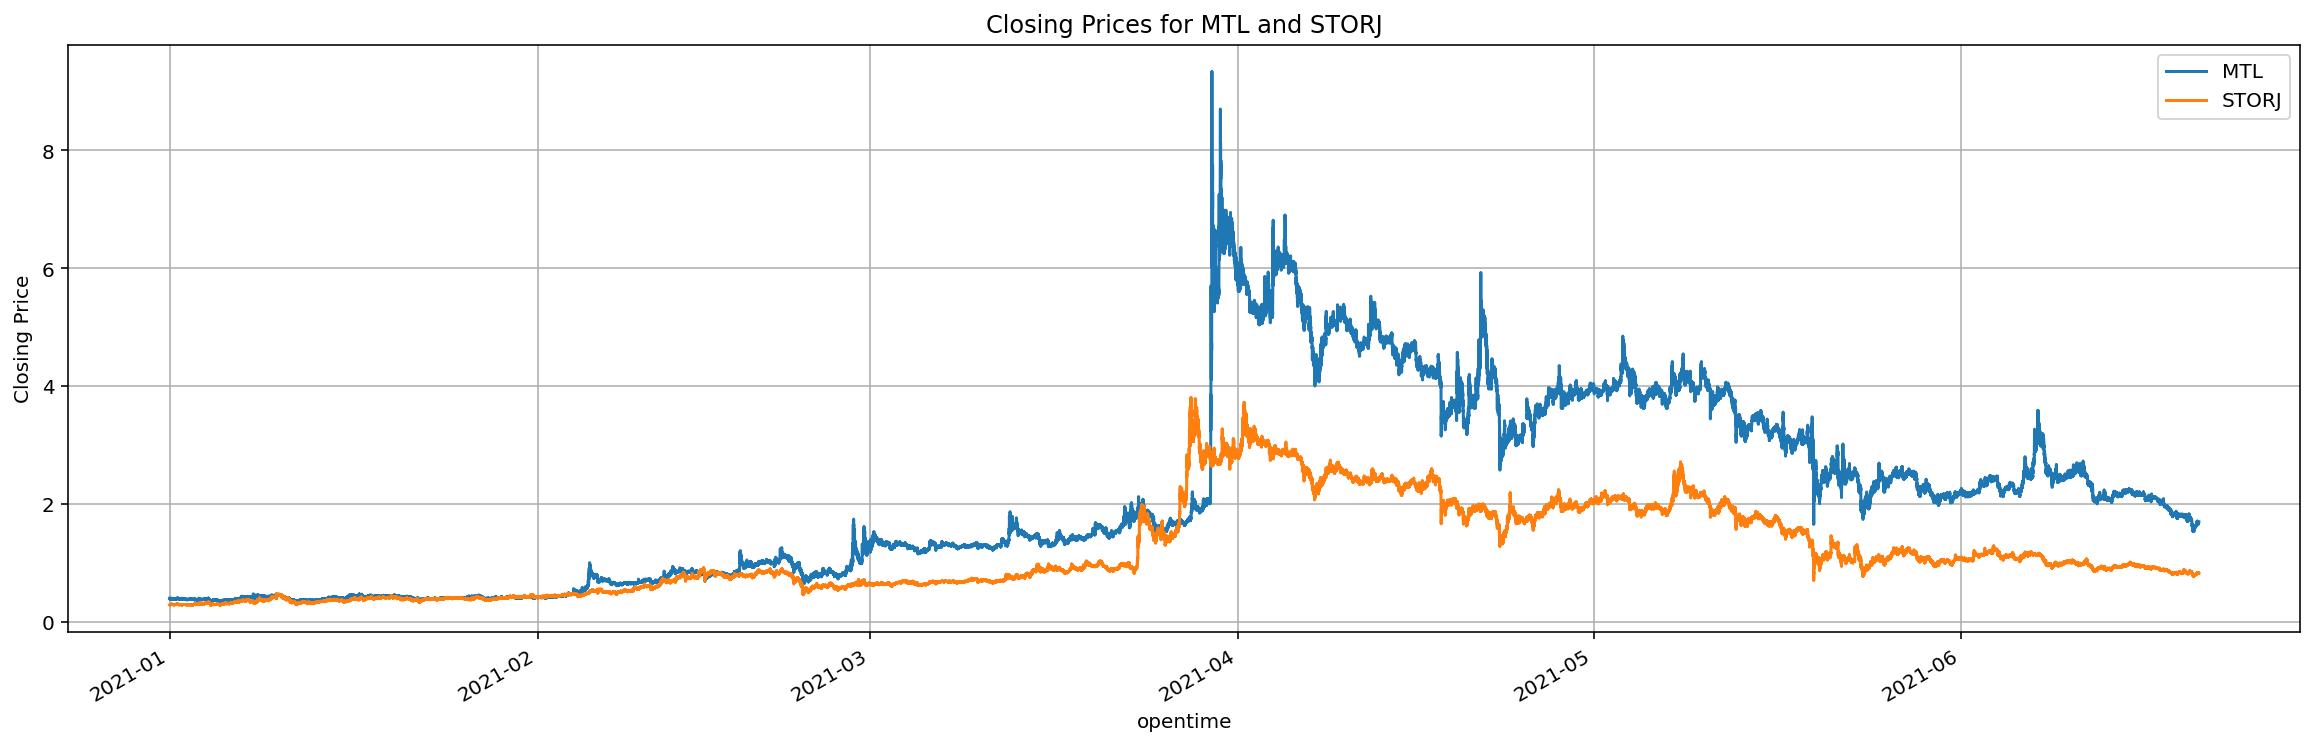

In [55]:
# visualize closing prices
ax = df[[asset1, asset2]].plot(figsize=(20, 6), title = 'Closing Prices for {} and {}'.format(asset1, asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);

In [56]:
# run OLS regression
model=sm.OLS(df_1h[asset1], df_1h[asset2]).fit()
print('Hedge Ratio = ', model.params[0])
# calculate spread
spread = df_1h[asset1] - model.params[0] * df_1h[asset2]


Hedge Ratio =  1.8443743911451866


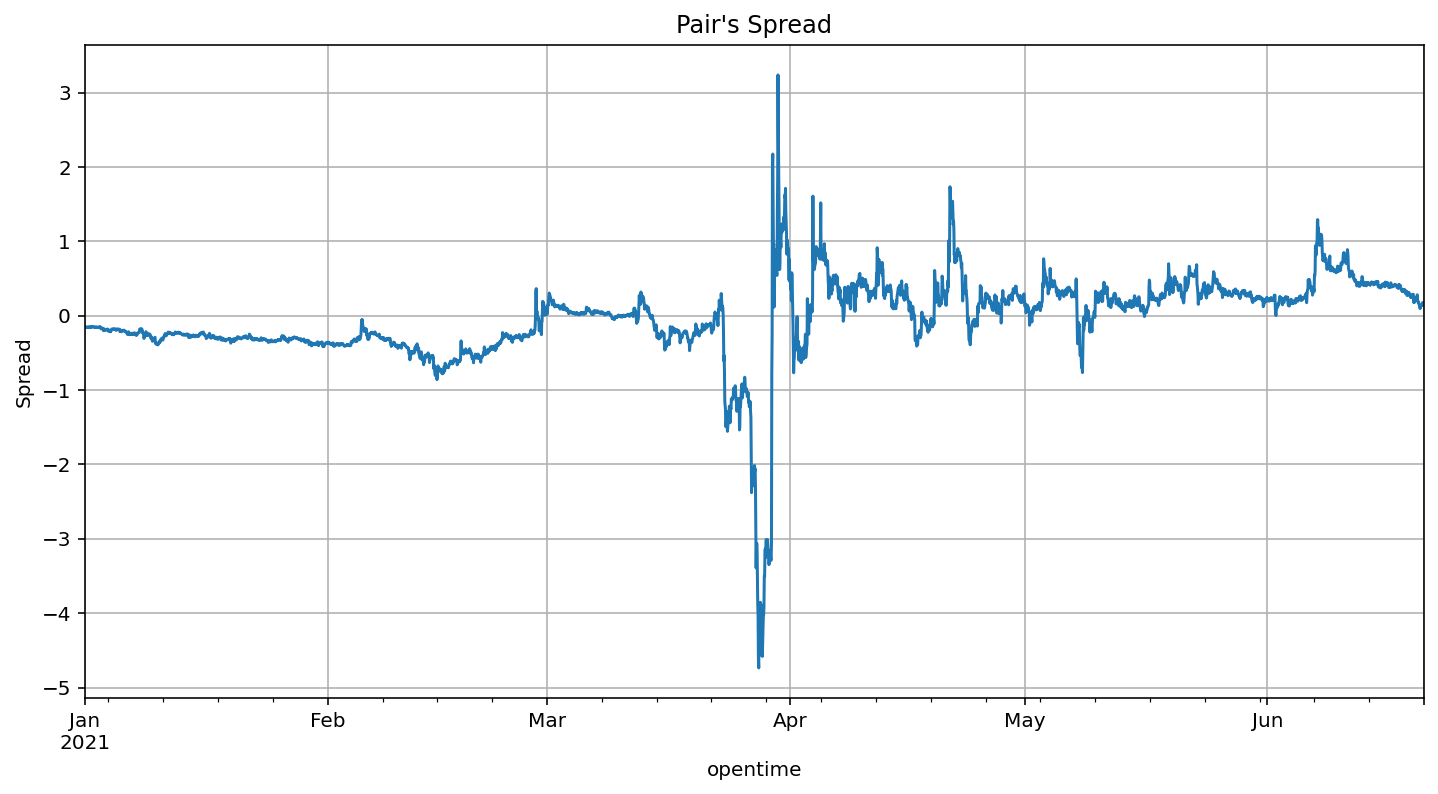

In [57]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

In [58]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [59]:
signals = pd.DataFrame()
ratios = df_1h[asset1] / df_1h[asset2]
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

(array([  49.,  242.,  958.,  303.,  284., 1180.,  760.,  258.,   61.,
          10.]),
 array([-2.4693566 , -1.93831537, -1.40727414, -0.87623291, -0.34519169,
         0.18584954,  0.71689077,  1.247932  ,  1.77897323,  2.31001446,
         2.84105568]),
 <BarContainer object of 10 artists>)

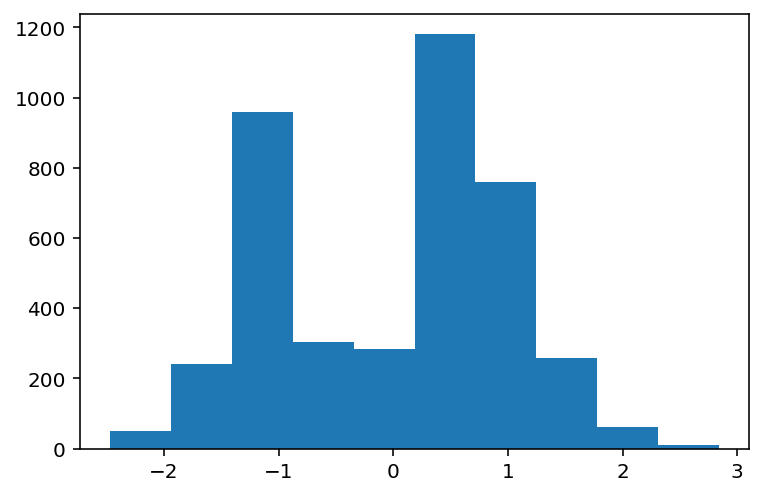

In [60]:
plt.hist(signals['z']) 

In [61]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=np.nan)
signals.fillna(method='ffill', inplace=True)

In [62]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [63]:
signals.head()

,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
opentime,,,,,,,
2021-01-01 00:00:00,-0.766938,1.0,-1.0,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,-0.796663,1.0,-1.0,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,-0.737788,1.0,-1.0,NaN,NaN,NaN,NaN
2021-01-01 03:00:00,-0.738401,1.0,-1.0,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,-0.776860,1.0,-1.0,NaN,NaN,NaN,NaN


In [65]:
signals['asset1'] = df_1h[asset1] 
signals['asset2'] = df_1h[asset2]

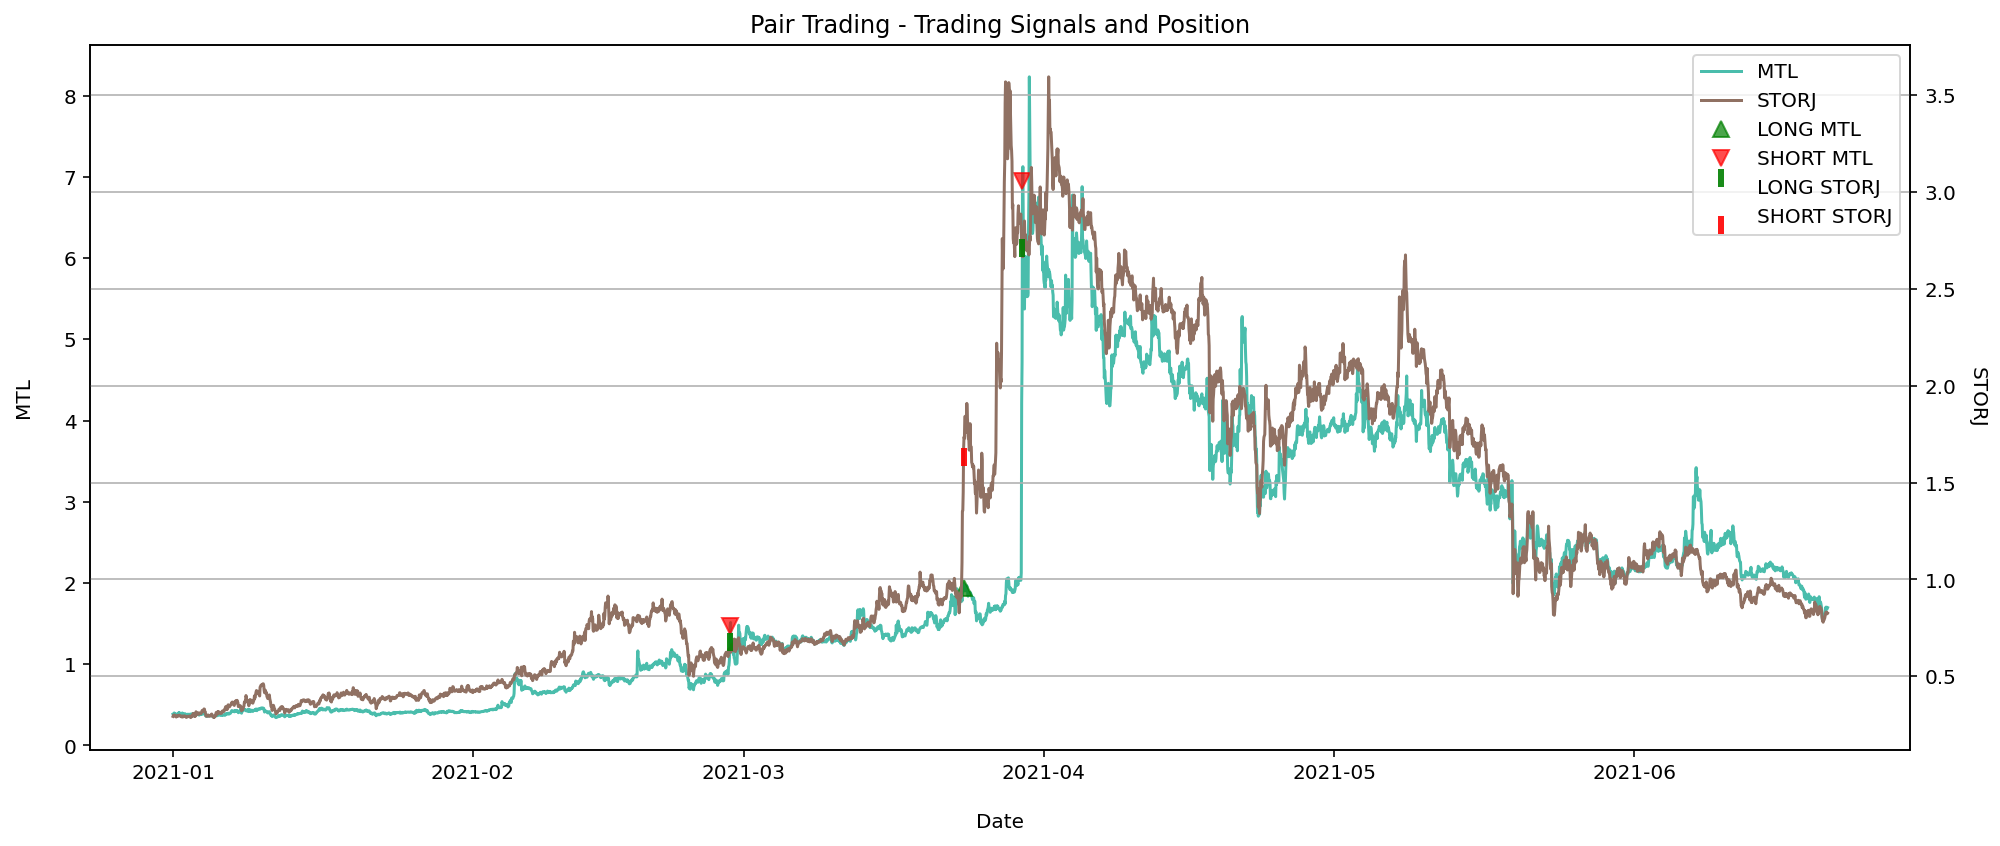

In [66]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 2], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -2], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 2], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -2], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()